# WordNetworks

## Configuration

In [32]:
slug = 'corpus1'
db_file = 'corpus1.db'
# vocab_weight = 'tfidf_sum'
vocab_weight = 'tf_sum'
vocab_weight_quantile = .94
vocab_min_n = 3
kde_kernel = 'gaussian'
kde_bandwidth = 2000
kde_samples = 1000

## Libraries

In [33]:
import pandas as pd
import numpy as np
import scipy as sp
import vsm_stage as vs
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.neighbors import KernelDensity as KDE

## Pragmas

In [34]:
from IPython.display import display, HTML
%matplotlib inline

## Functions

In [4]:
def get_term_id(vocab, term_str):
    return vocab[vocab.term_str == term_str].index[0]

def get_term_str(vocab, term_id):
    return vocab.loc[term_id].term_str

## Import tables from database

In [35]:
with sqlite3.connect(db_file) as db:
    V = pd.read_sql("SELECT * FROM vocab WHERE stop = 0", db, index_col='term_id')
    K = pd.read_sql("SELECT * FROM token WHERE term_id >= 0", db)

In [6]:
OHCO = ['book', 'chap_num', 'para_num', 'sent_num', 'token_num']
BOOKS = OHCO[:1]
CHAPS = OHCO[:2]
PARAS = OHCO[:3]
SENTS = OHCO[:4]

In [36]:
K1 = K[K.pos == 'NNP']
#V1 = V1[V1.index.isin(K1.term_id)]

In [37]:
BOW = vs.get_bow_from_token(K1, V, BOOKS)
DTM = vs.bow_to_dtm(BOW)
TF = vs.compute_tf(DTM, V)
TFIDF = vs.compute_tfidf(TF, DTM, V)
TFTH = vs.compute_tfth(TF)
V = vs.add_stats_to_V(V, TF, TFIDF, TFTH)

## Prepare Tokens index

with sqlite3.connect(db_file) as db:
    K = pd.read_sql("SELECT term_str, term_id FROM token WHERE term_id >= 0", db)
K.rename_axis('offset', inplace=True)

In [38]:
K.head()

,book,chapter,para_num,sent_num,token_num,pos,token_str,punc,num,term_str,term_id
0,A-Christmas-Carol,2,0,0,0,NNP,MARLEY'S,0,0,marleys,20027
1,A-Christmas-Carol,2,0,0,1,NNP,GHOST,0,0,ghost,13974
2,A-Christmas-Carol,2,1,0,0,NNP,Marley,0,0,marley,20026
3,A-Christmas-Carol,2,1,0,1,VBD,was,0,0,was,36250
4,A-Christmas-Carol,2,1,0,2,VBN,"dead,",0,0,dead,8132


## Filter Vocab

In [39]:
V.head()

,term_str,n,p,port_stem,stop,df,tf_sum,tf_mean,tf_max,tfidf_sum,tfidf_mean,tfidf_max,tfth_sum,tfth_mean,tfth_max,th_sum,th_mean,th_max
term_id,,,,,,,,,,,,,,,,,,
1,aaron,14,3.663176e-06,aaron,0,1.0,0.000686,0.00004,0.000686,0.002803,0.000165,0.002803,0.000005,2.906432e-07,0.000005,0.007206,0.000424,0.007206
2,aback,16,4.186487e-06,aback,0,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,abaft,1,2.616554e-07,abaft,0,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,abandon,33,8.634630e-06,abandon,0,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,abandoned,91,2.381065e-05,abandon,0,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
V1 = V[(V[vocab_weight] > V[vocab_weight].quantile(vocab_weight_quantile)) & (V.n >= vocab_min_n)]

In [41]:
V1.sort_values(vocab_weight, ascending=False).head(10).T

term_id,21223,21226,20782,28552,29560,18064,23981,18072,33402,36473
term_str,mr,mrs,miss,scrooge,sir,joe,pickwick,john,tom,weller
n,27957,8309,5652,277,8364,1140,2176,1703,1804,994
p,0.0073151,0.0021741,0.00147888,7.24786e-05,0.00218849,0.000298287,0.000569362,0.000445599,0.000472026,0.000260086
port_stem,mr,mr,miss,scroog,sir,joe,pickwick,john,tom,weller
stop,0,0,0,0,0,0,0,0,0,0
df,17,16,16,1,14,13,2,15,14,2
tf_sum,2.04948,0.571557,0.359111,0.224662,0.18112,0.15465,0.148163,0.13227,0.12558,0.114605
tf_mean,0.120557,0.033621,0.0211242,0.0132154,0.0106541,0.00909704,0.00871544,0.00778061,0.00738706,0.00674147
tf_max,0.24932,0.0700073,0.049786,0.224662,0.0388489,0.0910453,0.0946838,0.0452645,0.0649506,0.0738517
tfidf_sum,0,0.04999,0.0314089,0.918298,0.0507333,0.059853,0.457446,0.0238843,0.035176,0.353839


## Get list of top terms

In [42]:
TOP_TERMS = V1.sort_values(vocab_weight, ascending=False).term_str.head(30).tolist()
TOP_TERMS

['mr',
 'mrs',
 'miss',
 'scrooge',
 'sir',
 'joe',
 'pickwick',
 'john',
 'tom',
 'weller',
 'ill',
 'im',
 'trotty',
 'toby',
 'oliver',
 'sam',
 'bounderby',
 'nicholas',
 'london',
 'ghost',
 'richard',
 'christmas',
 'hugh',
 'quilp',
 'kit',
 'pecksniff',
 'dombey',
 'lord',
 'meg',
 'master']

## Filter tokens by vocab

In [43]:
select_cols = ['term_str', 'term_id']
K = pd.DataFrame(K, columns=select_cols)
K.rename_axis('offset', inplace=True)

In [44]:
K = K[K.term_id.isin(V1.index)]
K.head(11).T

offset,0,1,2,33,37,40,52,53,63,128,135
term_str,marleys,ghost,marley,scrooge,scrooges,good,old,marley,dont,therefore,marley
term_id,20027,13974,20026,28552,28553,14276,22325,20026,9823,32821,20026


## Create arrays of offsets for each term

In [45]:
B = K.reset_index().groupby(['term_str']).offset.apply(lambda x: x.tolist()).to_frame()
B['x'] = B.apply(lambda x: np.array(x.offset)[:, np.newaxis], 1)

In [46]:
B.head()

,offset,x
term_str,,
abbey,"[446258, 970277, 1040947, 1545246, 1835208, 20...","[[446258], [970277], [1040947], [1545246], [18..."
abel,"[1600598, 1602824, 1606972, 1607027, 1630774, ...","[[1600598], [1602824], [1606972], [1607027], [..."
ada,"[420932, 421400, 421630, 422001, 422209, 42228...","[[420932], [421400], [421630], [422001], [4222..."
affery,"[1775945, 1775958, 1776426, 1776796, 1776870, ...","[[1775945], [1775958], [1776426], [1776796], [..."
aged,"[309, 106514, 236202, 266248, 396644, 429033, ...","[[309], [106514], [236202], [266248], [396644]..."


## Get KDE for each term

In [47]:
scale_max = K.index.max() # THIS IS CRUCIAL
x_axis = np.linspace(0, scale_max, kde_samples)[:, np.newaxis]
B['kde'] = B.apply(lambda row: KDE(kernel=kde_kernel, bandwidth=kde_bandwidth).fit(row.x), 1)
B['scores'] = B.apply(lambda row: row.kde.score_samples(x_axis), axis=1)

## Visualize KDE plots

In [48]:
PLOTS = B.apply(lambda row: pd.Series(np.exp(row.scores) * (scale_max / kde_samples)), axis=1)
FIG = dict(figsize=(15, 5))

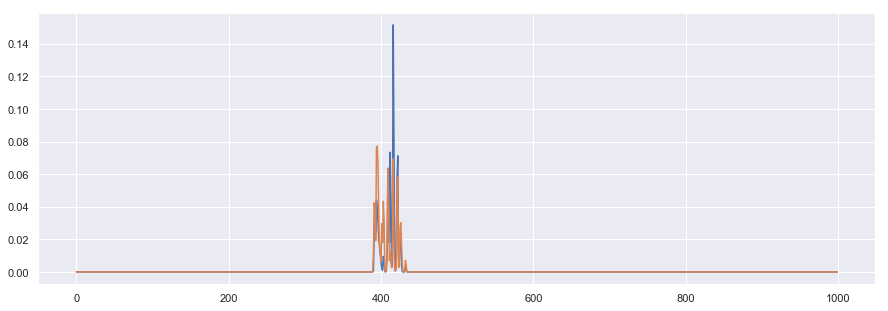

In [63]:
PLOTS.loc['estella'].plot(**FIG)
PLOTS.loc['havisham'].plot(**FIG)

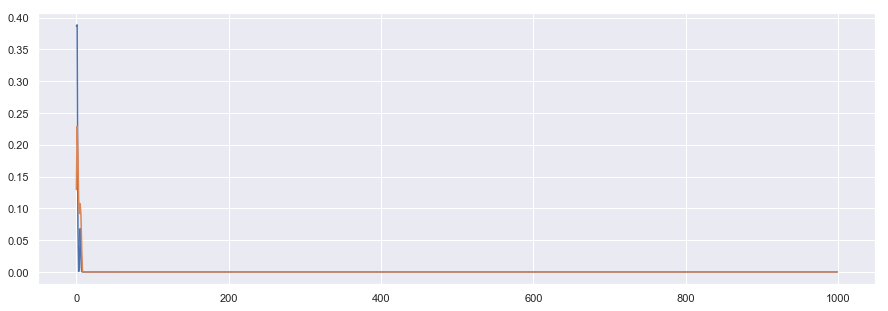

In [50]:
PLOTS.loc['marley'].plot(**FIG)
PLOTS.loc['scrooge'].plot(**FIG)

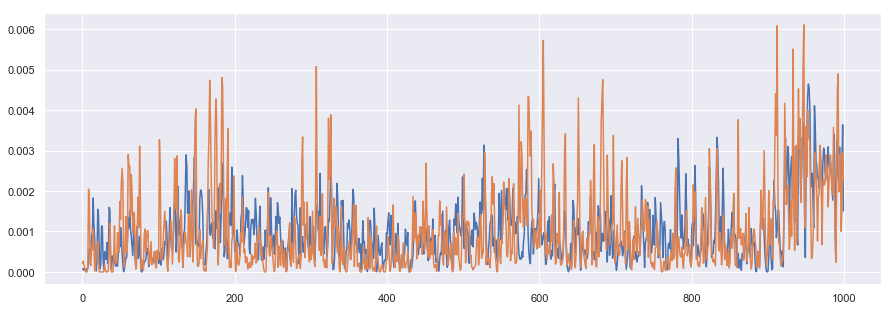

In [51]:
PLOTS.loc['mr'].plot(**FIG)
PLOTS.loc['sir'].plot(**FIG)

### Score pairs

In [52]:
pairs = pd.DataFrame([(x,y) for x in B.index for y in B.index if y > x] , columns=['x','y'])

### Compute overlap

In [22]:
def overlap(row):
    kde1 = PLOTS.loc[row.x]
    kde2 = PLOTS.loc[row.y]
    overlap = np.minimum(kde1, kde2)
    return np.trapz(overlap)

In [53]:
pairs['overlap'] = pairs.apply(overlap, axis=1)

In [24]:
def paircorr(row):
    return PLOTS.T[[row.x,row.y]].corr().values[0][1]

In [54]:
pairs['corr'] = pairs.apply(paircorr, axis=1)

### Skim Top Pairs

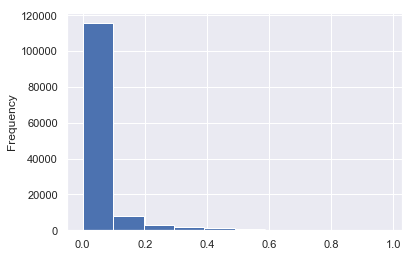

In [55]:
pairs.overlap.plot.hist()

In [56]:
pairs2 = pairs.copy().rename(columns={'x':'y', 'y':'x'})
pairs3 = pd.concat([pairs, pairs2], sort=True)

### Explore term correlations

In [57]:
CORR = pd.crosstab(pairs3.x, pairs3.y, pairs3.overlap, aggfunc='sum').fillna(1)

In [58]:
def corr_plot_terms(terms, dtm, title='Foo'):
    plt.figure(figsize = (20,20))
    print(title)
    corr = dtm[terms].corr()
    sns.heatmap(corr, vmax=.3, annot=True, center=0, 
              cmap='RdYlGn',
              square=True, linewidths=.5, 
              cbar_kws={"shrink": .5})
    plt.show()

TEST


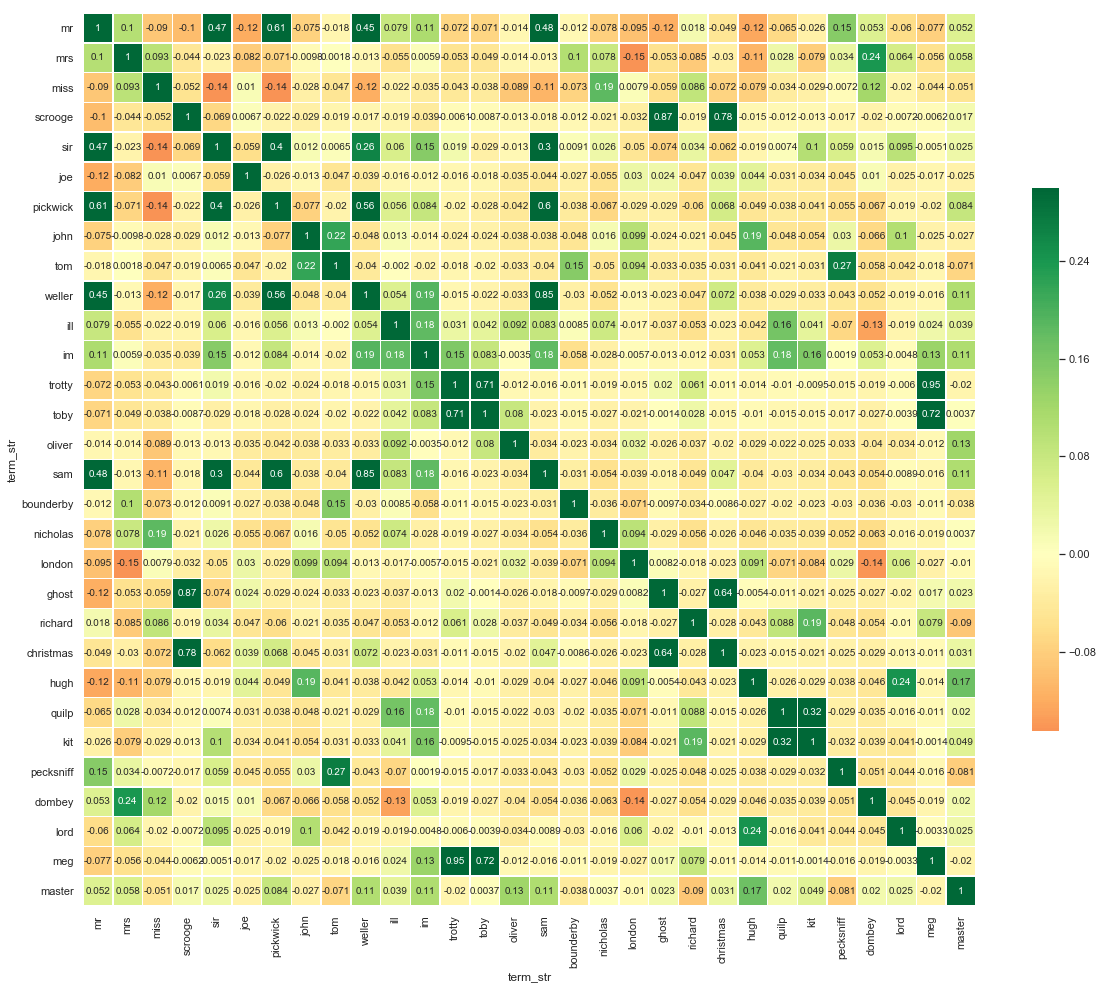

In [59]:
corr_plot_terms(TOP_TERMS, PLOTS.T, title='TEST')

### Export Graphs

In [60]:
import networkx as nx
slug = 'corpus1_noun'
G = nx.Graph()
edges = pairs[['x','y','overlap']].sort_values('overlap', ascending=False).head(1000).apply(lambda x: (x.x, x.y, x.overlap), axis=1).values
G.add_weighted_edges_from(edges)
nx.write_gexf(G, "{}.gexf".format(slug))

![alt text](c1_p1.png)

![alt text](c1_p2.png)